In [1]:
from point_env2 import *

obses = []

wandb.init(
    project=project_name,
    config={
        "env_config": ENV_CONFIG,
        "n_candidates": n_candidates,
        "batch": BATCH,
        "n_traj": N_TRAJ,
        "n_iter": N_ITER,
        "threshold": THRESHOLD,
        "n_traj_per_update": N_TRAJ_PER_UPDATE,
        "n_dynamic_buffer_free": N_DYNAMIC_BUFFER_FREE,
        "n_dynamic_buffer_danger": N_DYNAMIC_BUFFER_DANGER,
        "n_traj_buffer": N_TRAJ_BUFFER,
        "n_evaluate": N_EVALUATE,
        "patience": PATIENCE,
        "lr": LR,
        "hidden_size": HIDDEN_SIZE,
        "steer": STEER,
        "relabel": RELABEL,
        "explore_way": EXPLORE_WAY,
        "nominal_way": NOMINAL_WAY,
        "decay_relabel": DECAY_RELABEL,
        "scheduler": USE_SCHEDULER,
        "optimizer": OPTIMIZER,
        "min_explore_eps": MIN_EXPLORE_EPS,
        "max_explore_eps": MAX_EXPLORE_EPS,
        "decay_explore_rate": DECAY_EXPLORE_RATE,
        "decay_nominal_rate": DECAY_NOMINAL_RATE,
        "potential_obs": POTENTIAL_OBS,
        "train_on_hard": TRAIN_ON_HARD,
        "refine": REFINE_EPS,
        "relabel_only_agent": RELABEL_ONLY_AGENT,
        "all_lie": ALL_LIE,
        "lie_derive_safe": LIE_DERIVE_SAFE,
        "only_boundary": ONLY_BOUNDARY,
        "polyak": POLYAK,
        "pe_dim": PE_DIM,
        "fix_env": FIX_ENV,
        "max_visit_time": MAX_VISIT_TIME,
        "clip_norm": CLIP_NORM,
        "dynamic_relabel": DYNAMIC_RELABEL,
        "cbuf_agent": N_CBUF_AGENT,
        "cbuf_obstacle": N_CBUF_OBSTACLE,            
        "update_freq": UPDATE_FREQ,
        "min_lr": MIN_LR,
        "danger_threshold": DANGER_THRESHOLD,
        "all_explore": ALL_EXPLORE,
        "safe_explore": SAFE_EXPLORE,
        "danger_explore": DANGER_EXPLORE,
        "share_sample_across_update": SHARE_SAMPLE_ACROSS_UPDATE,
    },
    name=version_name,)

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# generate training data
dataset = []
for _ in tqdm(range(N_DATASET)):
    env = create_env()
    dataset.append([env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy(), 0])

# generate valid data
valid_dataset = []
for _ in tqdm(range(N_VALID_DATASET)):
    env = create_env()
    valid_dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))


Env = Env
env = create_env()
bnn = create_network()
swa_bnn = None

name_dict = generate_default_model_name(Env)
# bnn.load_state_dict(torch.load(name_dict['b'].replace('.pt', '_1model.pt'), map_location=device))

if OPTIMIZER=='SGD':
    boptimizer = torch.optim.SGD(bnn.parameters(), lr=LR, momentum=0.9, weight_decay=1e-8)
elif OPTIMIZER=='Adam':
    boptimizer = torch.optim.Adam(bnn.parameters(), lr=LR, weight_decay=1e-8)
else:
    assert False
if USE_SCHEDULER:
    bscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(boptimizer, factor=0.5, patience=PATIENCE, min_lr=MIN_LR)

max_episode_length = 256

running_unsafe_rate = 0
best_unsafe_rate = float('inf')
unsafe_rates = [1.]*N_EVALUATE
uncollide_rates = [1.]*N_EVALUATE
success_rates = [0.]*N_EVALUATE
fails = 0
nominal_eps = 1.0
explore_eps = 1.0

trajs = defaultdict(list)
# open(TXT_NAME, 'w+').close()
cbuf_obstacle = GlobalReplayBuffer(BATCH)
cbuf_agent = GlobalReplayBuffer(BATCH)
cbuf_dynamic_danger = GlobalReplayBuffer(BATCH)
cbuf_dynamic_free = GlobalReplayBuffer(BATCH)
bbuf_traj = TrajectoryReplayBuffer(BATCH)
bbuf_gather = GatherReplayBuffer(bnn=swa_bnn, dynamic_relabel=DYNAMIC_RELABEL, batch=BATCH)

for epoch_i in range(N_TRAJ):

    t0 = time()
    if epoch_i < N_WARMUP:
        explore_eps = 0.
    elif EXPLORE_WAY=='cyclic':
        explore_eps = (MAX_EXPLORE_EPS-(MAX_EXPLORE_EPS-MIN_EXPLORE_EPS)*((epoch_i-N_WARMUP) % 100)/100.)  # if ((epoch_i % 200) < 100) else 0.
    elif EXPLORE_WAY=='linear':
        explore_eps = np.clip(MAX_EXPLORE_EPS - DECAY_EXPLORE_RATE * ((epoch_i-N_WARMUP) // N_VALID), MIN_EXPLORE_EPS, MAX_EXPLORE_EPS)
    elif EXPLORE_WAY=='exponential':
        explore_eps = np.clip(MAX_EXPLORE_EPS * (DECAY_EXPLORE_RATE ** (((epoch_i-N_WARMUP) // N_VALID))), MIN_EXPLORE_EPS, MAX_EXPLORE_EPS)
    else:
        assert False

    if epoch_i < N_WARMUP:
        nominal_eps = 1.
    elif NOMINAL_WAY=='linear':
        nominal_eps = np.clip(1. - DECAY_NOMINAL_RATE * ((epoch_i-N_WARMUP) // N_VALID), 0, 1.)
    elif NOMINAL_WAY=='exponential':
        nominal_eps = DECAY_NOMINAL_RATE ** (1e-5 + ((epoch_i-N_WARMUP) // N_VALID))
    else:
        assert False

    if nominal_eps < 0.01:
        nominal_eps = 0

    if DECAY_RELABEL:
        relabel_eps = 1 - explore_eps # (epoch_i // N_VALID) / (N_TRAJ // N_VALID)
    else:
        relabel_eps = REFINE_EPS

    if (epoch_i % len(dataset) == 0):
        shuffle(dataset)

    torch.manual_seed(epoch_i)
    random.seed(epoch_i)
    np.random.seed(epoch_i)        

    bbuf = GlobalReplayBuffer()
    env = create_env()
    dataset[epoch_i%len(dataset)][-1] += 1; visit_time = 0
    if TRAIN_ON_HARD:
        if epoch_i > N_WARMUP:
            env.world.obstacles, env.world.agent_goals, env.world.agents, visit_time = deepcopy(dataset[epoch_i%len(dataset)])

    total_trans=0; n_danger=0; threshold=THRESHOLD; no_feasible=0; collided=np.zeros(env.num_agents).astype(bool); 
    volumes=[]; n_relabels=0; n_evils = []
    thresholds = [threshold]*env.num_agents

    while True:
        a, v, feasibles, evil_agents = choose_action(
                                        bnn=bnn,
                                        env=env,
                                        explore_eps=explore_eps, 
                                        nominal_eps=max(nominal_eps, int(epoch_i<N_WARMUP)), 
                                        spatial_prop=SPATIAL_PROP,
                                        n_action=n_candidates,
                                        thresholds=thresholds)
        n_evils.append(len(evil_agents))
        no_feasible += (env.num_agents - np.sum(feasibles))
        next_o, rw, done, info = env.step(a, obs_config=OBS_CONFIG)
        obses.append(next_o['agent'].x.data.cpu().numpy()[0])

        info['feasible'] = torch.FloatTensor(feasibles)
        bbuf.store(info.clone())
        prev_danger = info['prev_danger'].data.cpu().numpy().astype(bool)
        next_danger = info['next_danger'].data.cpu().numpy().astype(bool)
        if np.any(next_danger):
            collided = collided | next_danger

        total_trans += 1
        n_danger += np.array(next_danger).sum()
        volumes.append((v>threshold).mean())
        if LIE_DERIVE_SAFE:
            thresholds = 0.9*v+1e-2

        if done or (total_trans >= max_episode_length):
            bbuf.obs_buf[-1]['finished'] = True

            if (n_danger==0) or (visit_time > MAX_VISIT_TIME):
                # only preserve the hard envs
                dataset.pop(epoch_i%len(dataset))
                env = create_env()
                dataset.append([env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy(), 0])

            if (n_danger!=0):
                if RELABEL:
                    if epoch_i > N_WARMUP:
                        n_relabels = bbuf.relabel(relabel_eps) 

                for info in bbuf.obs_buf:
                    meet_agent = info['meet_agent'].data.cpu().numpy().astype(bool)                        
                    meet_obstacle = info['meet_obstacle'].data.cpu().numpy().astype(bool)                        
                    next_danger = info['next_danger'].data.cpu().numpy().astype(bool)                        
                    next_free = info['next_free'].data.cpu().numpy().astype(bool)                        
                    if meet_agent.any():
                        data = info.clone()
                        data['prev_free'] = torch.FloatTensor([False]*env.num_agents)
                        data['next_free'] = torch.FloatTensor([False]*env.num_agents)
                        data['next_danger'] = data['meet_agent']
                        cbuf_agent.store(data)  

                    if meet_obstacle.any():
                        data = info.clone()
                        data['prev_free'] = torch.FloatTensor([False]*env.num_agents)
                        data['next_free'] = torch.FloatTensor([False]*env.num_agents)
                        data['next_danger'] = data['meet_obstacle']
                        cbuf_obstacle.store(data)

                    if (next_danger & (~meet_obstacle) & (~meet_obstacle)).any():
                        data = info.clone()
                        data['prev_free'] = torch.FloatTensor([False]*env.num_agents)
                        data['next_free'] = torch.FloatTensor([False]*env.num_agents)
                        data['next_danger'] = torch.FloatTensor(next_danger & (~meet_obstacle) & (~meet_obstacle))
                        cbuf_dynamic_danger.store(data)   

                    if (next_free).any():
                        data = info.clone()
                        data['prev_free'] = torch.FloatTensor([False]*env.num_agents)
                        data['next_danger'] = torch.FloatTensor([False]*env.num_agents)
                        cbuf_dynamic_free.store(data)                              

            bbuf_traj.append(bbuf, collided)
            bbuf_gather.append(bbuf)
            break

        else:
            bbuf.obs_buf[-1]['finished'] = False

    fails += ((not done) or np.any(collided))
    unsafe_rates.append(collided.mean())
    unsafe_rates.pop(0)
    uncollide_rates.append(np.any(collided))
    uncollide_rates.pop(0)    
    success_rates.append(done and (not np.any(collided)))
    success_rates.pop(0)
    running_unsafe_rate = np.mean(unsafe_rates)

    wandb.log({'time/data_collection': time()-t0})           

    if (epoch_i > N_WARMUP) and (epoch_i % (N_VALID) == (N_VALID-1)):

        torch.save(bnn.state_dict(), BMODEL_PATH.replace('.pt', '_{0:d}.pt'.format(epoch_i // N_VALID)))

        break
        
        valid_loss = 0
        valid_success = 0
        valid_length = 0
        for v_idx, data in enumerate(valid_dataset):
            env = create_env(num_agents=len(data[2]))
            env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
            collided, done, gifs = infer(env, bnn, need_gif=None)
            valid_loss += np.mean(collided)
            valid_success += (done and (not np.any(collided)))
            valid_length += len(gifs)

        if USE_SCHEDULER:
            bscheduler.step(valid_loss/len(valid_dataset)+100*(1-valid_success/len(valid_dataset)))

        wandb.log({"valid/valid loss": valid_loss/len(valid_dataset),
                   "valid/valid length": valid_length/len(valid_dataset),
                   "valid/valid success": valid_success/len(valid_dataset),})  

    if epoch_i == 9:         
        print(bnn)        

    if (epoch_i % N_EVALUATE) == (N_EVALUATE-1) and (running_unsafe_rate!=0):
        if running_unsafe_rate < best_unsafe_rate:
            best_unsafe_rate = running_unsafe_rate
            torch.save(bnn.state_dict(), BMODEL_PATH)  

    if (fails % N_TRAJ_PER_UPDATE == (N_TRAJ_PER_UPDATE-1)) and (epoch_i > N_WARMUP):

        while len(bbuf_gather.dataset) > N_BUFFER:
            bbuf_gather.dataset.pop(0)

        while len(bbuf_traj.dataset) > N_TRAJ_BUFFER:
            bbuf_traj.dataset.data.pop(0)
            bbuf_traj.dataset.next_data.pop(0)

        while len(cbuf_agent.obs_buf) > N_CBUF_AGENT:
            cbuf_agent.obs_buf.pop(0)

        while len(cbuf_obstacle.obs_buf) > N_CBUF_OBSTACLE:
            cbuf_obstacle.obs_buf.pop(0) 

        while len(cbuf_dynamic_free.obs_buf) > N_DYNAMIC_BUFFER_FREE:
            cbuf_dynamic_free.obs_buf.pop(0)

        while len(cbuf_dynamic_danger.obs_buf) > N_DYNAMIC_BUFFER_DANGER:
            cbuf_dynamic_danger.obs_buf.pop(0) 

        t0 = time()
        bnn.train()
        if (swa_bnn is None) and (POLYAK != 0):
            swa_bnn = create_network()
            with torch.no_grad():
                for p, swa_p in zip(bnn.parameters(), swa_bnn.parameters()):
                    swa_p.data = deepcopy(p.data)
            bbuf_gather.bnn = swa_bnn

        train_barrier(bnn, swa_bnn, boptimizer, bbuf_traj, cbuf_dynamic_free, cbuf_dynamic_danger, cbuf_agent, cbuf_obstacle, 
                      n_iter=N_ITER, ) # int(total_trans//UPDATE_FREQ)
        wandb.log({'time/training': time()-t0})

        torch.save(bnn.state_dict(), BMODEL_PATH.replace('.pt', '_current.pt'))

        fails += 1


    if epoch_i < N_WARMUP:
        torch.save(bnn.state_dict(), BMODEL_PATH.replace('.pt', '_warmup.pt'))


    wandb.log({"loss/lr": boptimizer.param_groups[0]['lr'],
               "uncollide_rates": np.mean(uncollide_rates),
               "success_rates": np.mean(success_rates),
               "running_unsafe_rate": running_unsafe_rate,
               "explore_eps": explore_eps,
               "nominal_eps": nominal_eps,
               "relabel_prob": relabel_eps,
               "no_feasible": no_feasible,
               "volume": np.mean(volumes),
               "n_trans": total_trans,
               "n_relabels": n_relabels,
               "n_evils": np.mean(n_evils),
               "size/cbuf_obstacle": len(cbuf_obstacle),
               "size/cbuf_agent": len(cbuf_agent),
               "size/dybuf_free": len(cbuf_dynamic_free),
               "size/dybuf_danger": len(cbuf_dynamic_danger),
               "size/liebuf": len(bbuf_traj.dataset),
               "size/gather": len(bbuf_gather.dataset),
               "size/epoch_i": epoch_i})



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rainorangelemon (use `wandb login --relogin` to force relogin)


100%|██████████| 50/50 [00:00<00:00, 6722.29it/s]
/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch_geometric/nn/conv/hetero_conv.py:53: UserWarning: There exist node types ({'obstacle'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


OriginGNNv11(
  (embed): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (edge_embed): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (convs): ModuleList(
    (0): HeteroConv(num_relations=2)
    (1): HeteroConv(num_relations=2)
    (2): HeteroConv(num_relations=2)
  )
  (edge_mlps): ModuleList(
    (0): Sequential(
      (0): LazyLinear(in_features=0, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (1): Sequential(
      (0): LazyLinear(in_features=0, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): Sequential(
      (0): LazyLinear(in_features=0, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_featur

In [14]:
n_danger

0

In [12]:
can

[0]

In [7]:
env = create_env()
# gif_file = f'gifs/0505/point_v0/{idx}.gif'
collided, done, paths = infer(env,bnn,verbose=True)

----------------------------------------
0 0.05013494938611984 0.05013494938611984 (array([], dtype=int64),) (array([], dtype=int64),) set()
1 0.06657958030700684 0.06657958030700684 (array([], dtype=int64),) (array([], dtype=int64),) set()
2 0.08128494769334793 0.08128494769334793 (array([], dtype=int64),) (array([], dtype=int64),) set()
3 0.09867983311414719 0.09867983311414719 (array([], dtype=int64),) (array([], dtype=int64),) set()
4 0.12370187789201736 0.12370187789201736 (array([], dtype=int64),) (array([], dtype=int64),) set()
5 0.13916218280792236 0.13916218280792236 (array([], dtype=int64),) (array([], dtype=int64),) set()
6 0.14462441205978394 0.14462441205978394 (array([], dtype=int64),) (array([], dtype=int64),) set()
7 0.15515780448913574 0.15515780448913574 (array([], dtype=int64),) (array([], dtype=int64),) set()
8 0.16622182726860046 0.16622182726860046 (array([], dtype=int64),) (array([], dtype=int64),) set()
9 0.17562580108642578 0.17562580108642578 (array([], dtype=

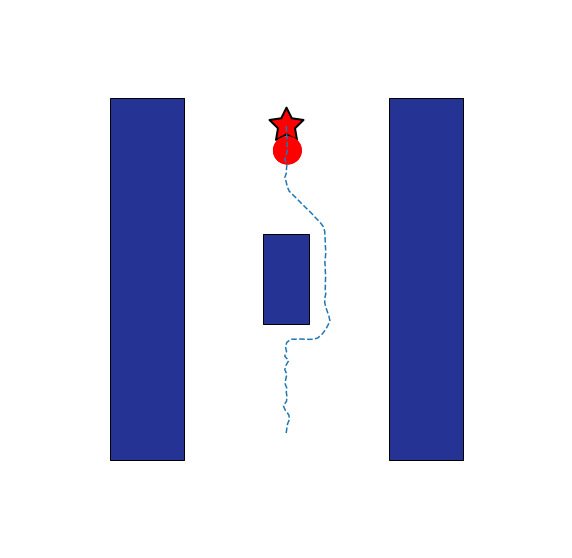

In [8]:
import matplotlib.pyplot as plt
paths = np.array(paths).reshape(-1,2)
paths = np.vstack((paths, env.world.agent_goals))
env._render()
plt.plot(paths[:,0], paths[:,1], linestyle='dashed')
plt.show()

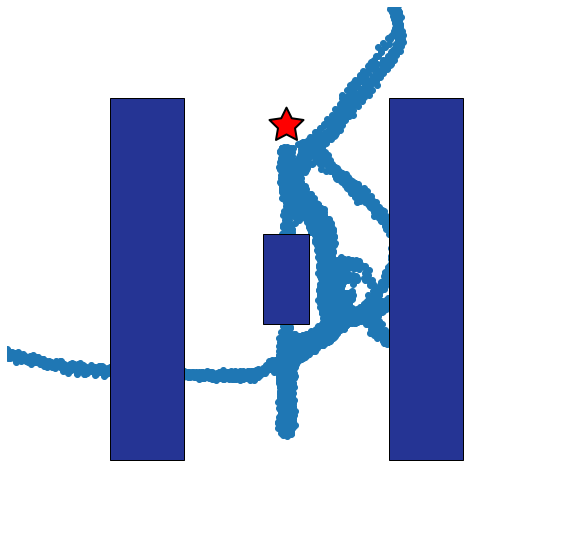

In [10]:
env.world.agents = np.array([[-100, -100]])
env._render()
plt.scatter(*np.array(obses).T)

In [11]:
%%time

num_grid = 200
threshold = THRESHOLD

pos_xs, pos_ys = np.meshgrid(np.linspace(-3, 3, num_grid), np.linspace(-3, 3, num_grid))
min_zs = []
max_zs = []

good_pos = []
volume_zs = []
is_boundary = []
worst_action = []
next_in_danger = []


bad_pos = []
bad_action = []

for pos_x, pos_y in tqdm(zip(pos_xs.reshape(-1), pos_ys.reshape(-1))):
        env.world.agents = np.array([[pos_x, pos_y]])
        y, x = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(-1, 1, 200))
        with torch.no_grad():
            action = torch.FloatTensor(np.hstack((y.reshape(-1, 1), x.reshape(-1, 1))))
            vec = bnn.get_vec(env._get_obs().to(device))
            z = bnn.get_field(vec.reshape(1, -1).repeat(len(action), 1), action.to(device)).data.cpu().numpy().reshape(-1)
        min_zs.append(np.min(z))
        max_zs.append(np.max(z))
        if np.any(z<threshold) and np.any(z>threshold):
            good_pos.append([pos_x, pos_y])
            worst_action.append(action[z.argmax()].cpu().data.numpy())
            volume_zs.append((z>=threshold).mean())

            pos_x, pos_y = np.array([pos_x, pos_y]) + 0.05 * worst_action[-1]
            env.world.agents = np.array([[pos_x, pos_y]])
            with torch.no_grad():
                action = torch.FloatTensor(np.hstack((y.reshape(-1, 1), x.reshape(-1, 1))))
                vec = bnn.get_vec(env._get_obs().to(device))
                z = bnn.get_field(vec.reshape(1, -1).repeat(len(action), 1), action.to(device)).data.cpu().numpy().reshape(-1)
            next_in_danger.append(False if z.max()>threshold else True)
            
        if np.all(z<threshold):
            bad_pos.append([pos_x, pos_y])
            bad_action.append(action[z.argmax()].cpu().data.numpy())

threshold = 2e-2
z = z - threshold
min_zs = np.array(min_zs) - threshold
max_zs = np.array(max_zs) - threshold

40000it [00:44, 890.17it/s] 

CPU times: user 5min 53s, sys: 5.53 s, total: 5min 59s
Wall time: 44.9 s


ValueError: not enough values to unpack (expected 2, got 1)

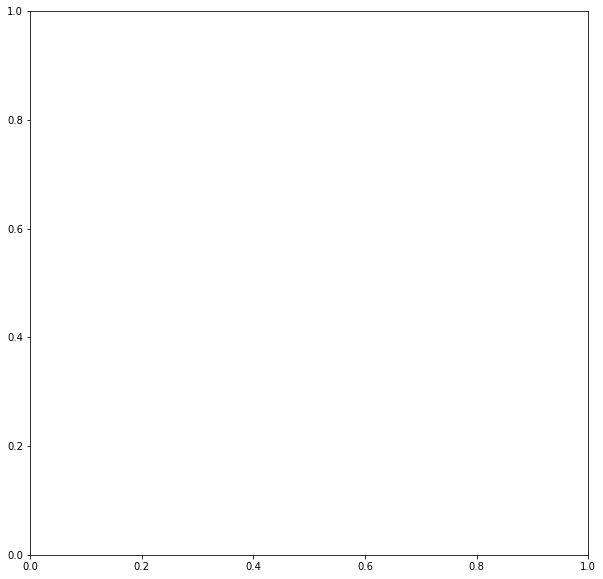

In [12]:
import matplotlib.pyplot as plt
import numpy as np

z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots(figsize=(10, 10))

c = ax.pcolormesh(x, y, z, cmap='inferno', vmin=z_min, vmax=z_max)
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()
env._render();

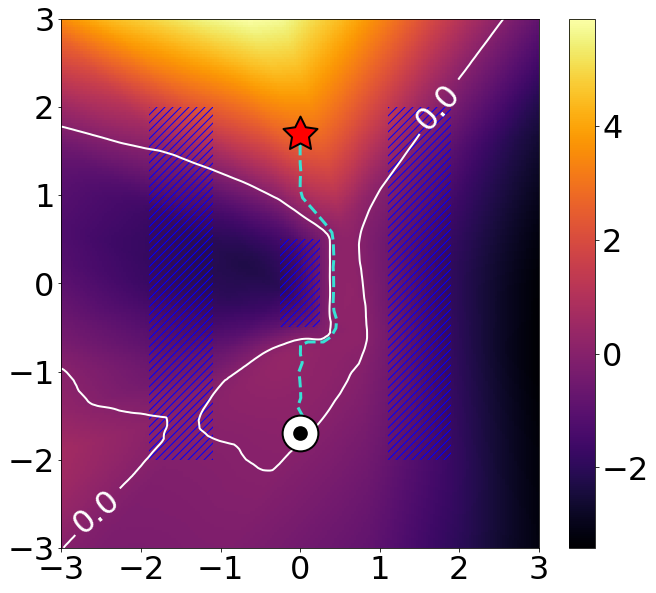

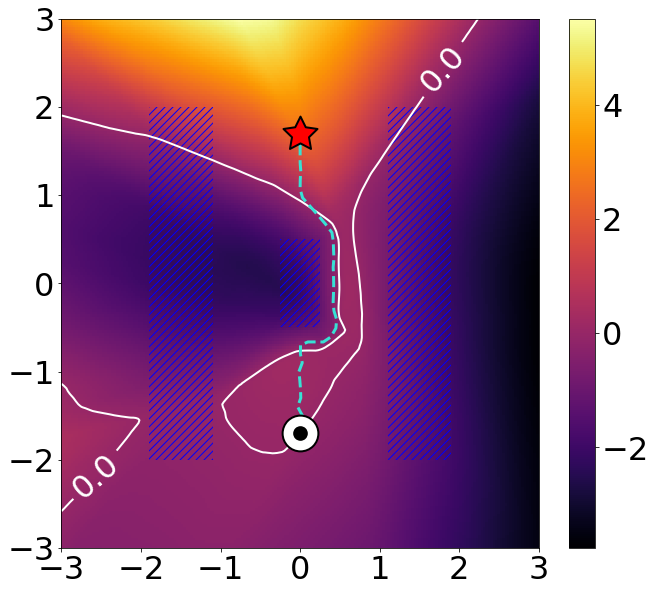

ValueError: cannot reshape array of size 2973 into shape (200,200)

Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 149, in check_network_status
    status_response = self._interface.communicate_network_status()
  File "/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 125, in communicate_network_status
    resp = self._communicate_network_status(status)
  File "/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/wandb/sdk/interface/interface_shared.py", line 397, in _communicate_network_status
    resp = self._communicate(req, local=True)
  File "/home/rainorangelemon/anaconda3/envs/gnn/lib/pyt

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns

plt.rcParams.update({'font.size': 32})
z = np.array(max_zs).reshape(pos_ys.shape)
z_min, z_max = z.min(), z.max()


paths = np.array(paths).reshape(-1, 2)

plt.clf()
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 9))

c = ax.pcolormesh(pos_xs, pos_ys, z, cmap='inferno', vmin=z_min, vmax=z_max, zorder=1)
# set the limits of the plot to the limits of the data
ax.axis([pos_xs.min(), pos_xs.max(), pos_ys.min(), pos_ys.max()])

CS = plt.contour(pos_xs, pos_ys, z, levels = [0],
                 colors=('white',),linestyles=('-',),linewidths=(2,))
plt.clabel(CS, fmt = '0.0', colors = 'white', fontsize=32) #contour line labels

for obstacle in env.world.obstacles:
        center_x, center_y, dx, dy = obstacle
        rectangle = patches.Rectangle((center_x-dx, center_y-dy), 2*dx, 2*dy, 
                                      linewidth=0, edgecolor='blue', facecolor='none', hatch='///')
        plt.gca().add_patch(rectangle)
colors=env.initColors()
for color, agent, goal in zip(colors.values(), env.world.agents, env.world.agent_goals):
    plt.scatter(goal[0], goal[1], s=1280, color='none', linewidths=2, marker=(5, 1), facecolors=['red'], edgecolors=['black'], zorder=3)
    plt.scatter(0, -1.7, s=1280, color="white", edgecolor="black", linewidths=2, zorder=3)
    plt.scatter(0, -1.7, s=160, color="black", edgecolor="black", linewidths=2, zorder=3)

ax.set_xticks([-3,-2,-1,0,1,2,3])
plt.plot(paths[::2,0], paths[::2,1], linestyle='--', color=(55/256, 226/256, 213/256), dash_joinstyle='round', linewidth=3, zorder=2)
cbar = fig.colorbar(c, ax=ax)
fig.tight_layout()
plt.savefig('azhe1.pdf')
plt.show()


z = np.array(min_zs).reshape(pos_ys.shape)
z_min, z_max = z.min(), z.max()


plt.clf()
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 9))

c = ax.pcolormesh(pos_xs, pos_ys, z, cmap='inferno', vmin=z_min, vmax=z_max, zorder=1)
# set the limits of the plot to the limits of the data
ax.axis([pos_xs.min(), pos_xs.max(), pos_ys.min(), pos_ys.max()])

CS = plt.contour(pos_xs, pos_ys, z, levels = [0],
                 colors=('white',),linestyles=('-',),linewidths=(2,))
plt.clabel(CS, fmt = '0.0', colors = 'white', fontsize=32) #contour line labels

for obstacle in env.world.obstacles:
        center_x, center_y, dx, dy = obstacle
        rectangle = patches.Rectangle((center_x-dx, center_y-dy), 2*dx, 2*dy, linewidth=0, 
                                      edgecolor='blue', facecolor='none', hatch='///')
        plt.gca().add_patch(rectangle)
colors=env.initColors()
for color, agent, goal in zip(colors.values(), env.world.agents, env.world.agent_goals):
    plt.scatter(goal[0], goal[1], s=1280, color='none', linewidths=2, marker=(5, 1), facecolors=['red'], edgecolors=['black'], zorder=3)
    plt.scatter(0, -1.7, s=1280, color="white", edgecolor="black", linewidths=2, zorder=3)
    plt.scatter(0, -1.7, s=160, color="black", edgecolor="black", linewidths=2, zorder=3)

ax.set_xticks([-3,-2,-1,0,1,2,3])
plt.plot(paths[::2,0], paths[::2,1], linestyle='--', color=(55/256, 226/256, 213/256), dash_joinstyle='round', linewidth=3, zorder=2)
fig.colorbar(c, ax=ax)
fig.tight_layout()
plt.savefig('azhe2.pdf')
plt.show()
z = np.array(volume_zs).reshape(pos_ys.shape)
z_min, z_max = z.min(), z.max()


plt.clf()
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 9))
# 'copper'  'cividis' sns.cubehelix_palette(as_cmap=True) sns.color_palette("light:#5A9", as_cmap=True), sns.color_palette("vlag", as_cmap=True)
c = ax.contourf(pos_xs, pos_ys, z, cmap=sns.color_palette("vlag", as_cmap=True), vmin=-1, vmax=1.1, zorder=1)
# set the limits of the plot to the limits of the data
ax.axis([pos_xs.min(), pos_xs.max(), pos_ys.min(), pos_ys.max()])

for obstacle in env.world.obstacles:
        center_x, center_y, dx, dy = obstacle
        rectangle = patches.Rectangle((center_x-dx, center_y-dy), 2*dx, 2*dy, linewidth=0, 
                                      edgecolor='blue', facecolor='none', hatch='///')
        plt.gca().add_patch(rectangle)
colors=env.initColors()
for color, agent, goal in zip(colors.values(), env.world.agents, env.world.agent_goals):
    plt.scatter(goal[0], goal[1], s=1280, color='none', linewidths=2, marker=(5, 1), facecolors=['red'], edgecolors=['black'], zorder=3)
    plt.scatter(0, -1.7, s=1280, color="white", edgecolor="black", linewidths=2, zorder=3)
    plt.scatter(0, -1.7, s=160, color="black", edgecolor="black", linewidths=2, zorder=3)

ax.set_xticks([-3,-2,-1,0,1,2,3])
plt.plot(paths[::2,0], paths[::2,1], linestyle='--', color=(55/256, 226/256, 213/256), dash_joinstyle='round', linewidth=3, zorder=2)
cbar = fig.colorbar(c, ax=ax, extend='neither', spacing='proportional', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
fig.tight_layout()
plt.savefig('azhe3.pdf')
plt.show()


plt.clf()
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 9))
# 'copper'  'cividis' sns.cubehelix_palette(as_cmap=True) sns.color_palette("light:#5A9", as_cmap=True), sns.color_palette("vlag", as_cmap=True)
# set the limits of the plot to the limits of the data
ax.axis([pos_xs.min(), pos_xs.max(), pos_ys.min(), pos_ys.max()])

colors=env.initColors()
for color, agent, goal in zip(colors.values(), env.world.agents, env.world.agent_goals):
    plt.scatter(goal[0], goal[1], s=1280, color='none', linewidths=2, marker=(5, 1), facecolors=['red'], edgecolors=['black'], zorder=3)
    plt.scatter(0, -1.7, s=1280, color="white", edgecolor="black", linewidths=2, zorder=3)
    plt.scatter(0, -1.7, s=160, color="black", edgecolor="black", linewidths=2, zorder=3)

ax.set_xticks([-3,-2,-1,0,1,2,3])
plt.plot(paths[::2,0], paths[::2,1], linestyle='--', color=(55/256, 226/256, 213/256), dash_joinstyle='round', linewidth=3, zorder=2)

interval = 4

pos = np.array(good_pos)[~np.array(next_in_danger)][::interval]
next_pos = (pos+0.05*np.array(worst_action)[~np.array(next_in_danger)][::interval])
next_in_danger_ = np.array(next_in_danger)[~np.array(next_in_danger)][::interval]
arrows = [patches.FancyArrow(x1, y1, x2-x1, y2-y1,
                                  length_includes_head=True, width=0.01, head_length=0.5*((x2-x1)**2+(y2-y1)**2)**0.5) for d, x1, y1, x2, y2 in zip(next_in_danger_, pos[:,0], pos[:,1], next_pos[:,0], next_pos[:,1])]
agent_arrows = PatchCollection(arrows,)
ax.add_collection(agent_arrows)


interval = 1

pos = np.array(good_pos)[np.array(next_in_danger)][::interval]
next_pos = (pos+0.05*np.array(worst_action)[np.array(next_in_danger)][::interval])
next_in_danger_ = np.array(next_in_danger)[np.array(next_in_danger)][::interval]
arrows = [patches.FancyArrow(x1, y1, x2-x1, y2-y1,
                                  length_includes_head=True, width=0.01, head_length=0.5*((x2-x1)**2+(y2-y1)**2)**0.5) for d, x1, y1, x2, y2 in zip(next_in_danger_, pos[:,0], pos[:,1], next_pos[:,0], next_pos[:,1])]
agent_arrows = PatchCollection(arrows, facecolor='red')
ax.add_collection(agent_arrows)


interval = 4
pos = np.array(bad_pos)[::interval]
next_pos = (pos+0.05*np.array(bad_action)[::interval])
arrows = [patches.FancyArrow(x1, y1, x2-x1, y2-y1,
                                  length_includes_head=True, width=0.01, head_length=0.5*((x2-x1)**2+(y2-y1)**2)**0.5) for x1, y1, x2, y2 in zip(pos[:,0], pos[:,1], next_pos[:,0], next_pos[:,1])]
agent_arrows = PatchCollection(arrows, facecolor='green')
ax.add_collection(agent_arrows)

fig.tight_layout()
plt.savefig('azhe4.pdf')
plt.show()